In [ ]:
import pandas as pd
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# path = 'dataset/' #change to your data location
# # load downloaded data
# df_convos = pd.read_csv(path+'/conversations.csv')
# df_speakers = pd.read_csv(path+'/speakers.csv')
# df_utts = pd.read_csv(path+'/utterances.csv')
# df_cases = pd.read_json(path_or_buf=path+'/cases.jsonl', lines=True)
# df_cases = df_cases[(df_cases['year'] >= 2011) & (df_cases['year'] <= 2018) & (df_cases['win_side'].isin([0,1]))]

In [ ]:
path = 'http://rezarzky.my.id/dataset/' #change to your data location
# load downloaded data
df_convos = pd.read_csv(path+'/conversations.csv')
df_speakers = pd.read_csv(path+'/speakers.csv')
df_utts = pd.read_csv(path+'/utterances.csv')
df_cases = pd.read_json(path_or_buf='https://zissou.infosci.cornell.edu/convokit/datasets/supreme-corpus/cases.jsonl', lines=True)
df_cases = df_cases[(df_cases['year'] >= 2011) & (df_cases['year'] <= 2018) & (df_cases['win_side'].isin([0,1]))]

In [ ]:
# count number win/lose cases
df_cases['win_side'].value_counts()

1.0    400
0.0    201
Name: win_side, dtype: int64

In [ ]:
# combine text from all utterances in a conversation back into one string based on the conversation_id, coount how many utterances per conversation
utt_per_conv = df_utts.groupby('conversation_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
utt_per_conv['num_utterances'] = df_utts.groupby('conversation_id')['text'].count().reset_index()['text']

# add the combined text to the conversations dataframe, merge on conversation_id in utt_per_conv and id in df_convo
df_convos_utt = df_convos.merge(utt_per_conv, left_on='id', right_on='conversation_id', how='left')

In [ ]:
# combine text from all conversation in a cases into one string based on the meta.case_id
conv_per_case = df_convos_utt.groupby('meta.case_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
conv_per_case['num_conversations'] = df_convos_utt.groupby('meta.case_id')['text'].count().reset_index()['text']
conv_per_case['num_utterances'] = df_convos_utt.groupby('meta.case_id')['num_utterances'].sum().reset_index()['num_utterances']

# add the combined text case dataframe, merge on meta.case_id and id
df_cases_convo = df_cases.merge(conv_per_case, left_on='id', right_on='meta.case_id', how='left')
df_cases_convo.head(3)

,id,year,citation,title,petitioner,respondent,docket_no,court,decided_date,url,...,win_side_detail,scdb_docket_id,votes,votes_detail,is_eq_divided,votes_side,meta.case_id,text,num_conversations,num_utterances
0,2011_11-1179,2011,567 US _,"American Tradition Partnership, Inc. v. Bullock","American Tradition Partnership, Inc.","Steve Bullock, Attorney General of Montana, et...",11-1179,Roberts Court,"Jun 25, 2012",https://www.oyez.org/cases/2011/11-1179,...,3.0,2011-073-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",NaN,NaN,NaN,NaN
1,2011_11-182,2011,567 US _,Arizona v. United States,Arizona et al.,United States,11-182,Roberts Court,"Jun 25, 2012",https://www.oyez.org/cases/2011/11-182,...,7.0,2011-075-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 0.0, 'j__antonin_scal...",2011_11-182,We'll hear argument this morning in Case 11-18...,1.0,295.0
2,2011_11-161,2011,566 US _,Armour v. City of Indianapolis,Christine Armour,City of Indianapolis,11-161,Roberts Court,"Jun 4, 2012",https://www.oyez.org/cases/2011/11-161,...,2.0,2011-062-01,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",2011_11-161,We will hear argument this morning in case 11-...,1.0,239.0


In [ ]:
df_cases_convo.dropna(subset=['text'], inplace=True)
df_cases_convo.shape[0]

521

In [ ]:
# Cleaning the text
def preprocess_text(text):
    text = text.lower() # Lowercase the text
    text = re.sub('[^a-z]+', ' ', text)  # Remove special characters and numbers
    text = re.sub(r'\b\w{1,3}\b', '', text) # Remove words with length less than 3
    words = nltk.word_tokenize(text) # Tokenize the text
    stop_words = set(stopwords.words('english')) # Remove stopwords
    words = [word for word in words if word not in stop_words]
    #lemmatizer = WordNetLemmatizer() # Lemmatize the words comment because slow
    #words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words) # Reconstruct the text

    return text

In [ ]:
text = df_cases_convo.loc[:,['text','win_side']]
text.head(3)

,text,win_side
1,We'll hear argument this morning in Case 11-18...,0.0
2,We will hear argument this morning in case 11-...,0.0
3,We will hear argument first this morning in Ca...,1.0


In [ ]:
text['text'] = text['text'].apply(preprocess_text) #apply preprocess
text.head(10)

,text,win_side
1,hear argument morning case arizona united stat...,0.0
2,hear argument morning case armour city indiana...,0.0
3,hear argument first morning case astrue capato...,1.0
4,hear argument next case blueford arkansas sloa...,0.0
6,hear argument first morning case caraco pharma...,1.0
8,hear argument morning case christopher smithkl...,0.0
10,hear argument first morning case coleman court...,0.0
11,hear argument next case compucredit corporatio...,1.0
12,hear argument next case number credit suisse s...,1.0
13,hear argument morning case dorsey united state...,1.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import numpy as np

#bag of words
bow_converter = CountVectorizer()
x = bow_converter.fit_transform(text['text'])
words = bow_converter.vocabulary_.keys()
len(words)

28920

In [ ]:
#bag of n-grams
bigram_converter = CountVectorizer(ngram_range=(2,2)) 
x2 = bigram_converter.fit_transform(text['text'])
bigrams = bigram_converter.get_feature_names_out()

In [ ]:
trigram_converter = CountVectorizer(ngram_range=(3,3))
x3 = trigram_converter.fit_transform(text['text'])
trigram = trigram_converter.get_feature_names_out()

In [ ]:

quadgram_converter= CountVectorizer(ngram_range=(4,4)) 
x4 = quadgram_converter.fit_transform(text['text'])
quadgram = quadgram_converter.get_feature_names_out()

cinqgram_converter= CountVectorizer(ngram_range=(5,5)) 
x5 = quadgram_converter.fit_transform(text['text'])
quadgram = quadgram_converter.get_feature_names_out()

sixgram_converter= CountVectorizer(ngram_range=(6,6)) 
x6 = sixgram_converter.fit_transform(text['text'])
sixgram = sixgram_converter.get_feature_names_out()

septgram_converter= CountVectorizer(ngram_range=(7,7)) 
x7 = septgram_converter.fit_transform(text['text'])
septgram = septgram_converter.get_feature_names_out()

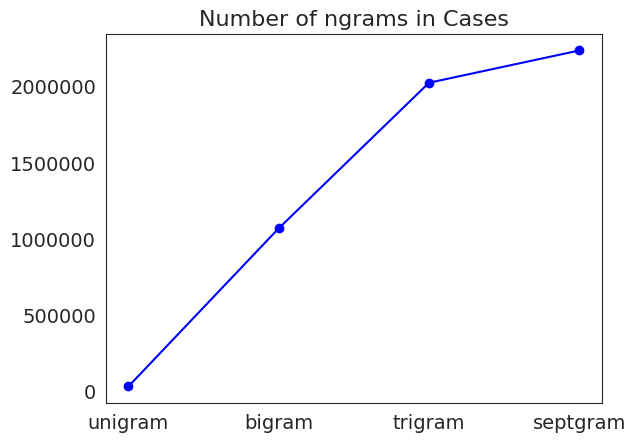

In [ ]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigram), len(septgram) ]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(4), ['unigram', 'bigram', 'trigram', 'septgram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams in Cases', {'fontsize':16})
plt.show()

In [ ]:
from sklearn.feature_extraction import text


Bag of Words Transformation


In [ ]:
X = text['text']
y =  text['win_side']

training_data, test_data = train_test_split(text, random_state=42)
bow_transform = CountVectorizer(ngram_range=(3,3), lowercase=False) 



In [ ]:
X_tr_bow = bow_transform.fit_transform(training_data['text'])


In [ ]:
len(bow_transform.vocabulary_)


2214078

In [ ]:
X_tr_bow.shape


(390, 2214078)

In [ ]:
X_te_bow = bow_transform.transform(test_data['text'])


In [ ]:
y_tr = training_data['win_side']
y_te = test_data['win_side']

In [ ]:
# Create the tf-idf representation using the bag-of-words matrix
from sklearn.feature_extraction import text


tfidf_transform = text.TfidfTransformer()
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [ ]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)


Classification with Logistic Regression


In [ ]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [ ]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')


Test Score with bow features 0.6564885496183206
Test Score with tf-idf features 0.6641221374045801


In [ ]:
import sklearn.model_selection

param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search =sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [ ]:
bow_search.fit(X_tr_bow, y_tr)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
bow_search.best_score_


0.6256410256410256

In [ ]:
tfidf_search.fit(X_tr_tfidf, y_tr)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
tfidf_search.best_score_


0.6256410256410256

In [ ]:
bow_search.best_params_


{'C': 1e-05}

In [ ]:
tfidf_search.best_params_


{'C': 1e-05}

In [ ]:
bow_search.cv_results_


{'mean_fit_time': array([13.27562661, 19.39422917, 27.39296756, 28.68174825, 30.77088923,
        20.50505261]),
 'std_fit_time': array([1.69049347, 0.76807263, 0.93387687, 1.48087482, 1.05447008,
        1.94858288]),
 'mean_score_time': array([0.00862556, 0.00819273, 0.00906992, 0.00925088, 0.00922804,
        0.01067486]),
 'std_score_time': array([0.00146609, 0.00073957, 0.00164712, 0.00196291, 0.00139663,
        0.00182396]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.62820513, 0.61538462, 0.61538462, 0.61538462, 0.61538462,
        0.61538462]),
 'split1_test_score': array([0.62820513, 0.62820513, 0.61538462, 0.61538462, 0.61538462,
        0.6025641 ]),
 'split2_test_score': array([0.62820513, 0.61538462, 0.6

In [ ]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf
0,0.625641,0.625641
1,0.623077,0.625641
2,0.612821,0.625641
3,0.615385,0.625641
4,0.615385,0.625641
5,0.607692,0.625641


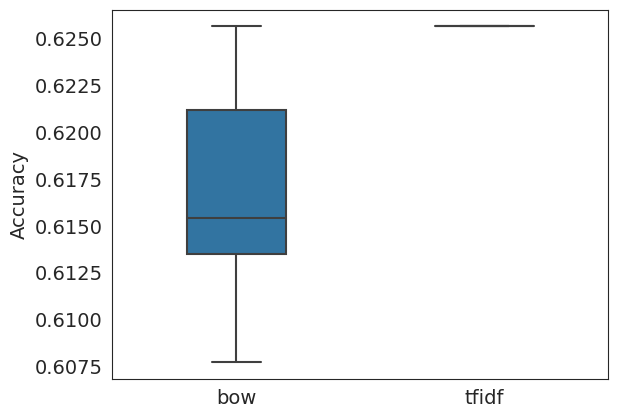

In [ ]:
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)


In [ ]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test Score with bow features 0.6641221374045801
Test Score with tf-idf features 0.6641221374045801
